In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [11]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,2.682191,3.261983,-24.060120,-18.813720,2.679608,4.724000
1,0.217510,-1.491017,1.408883,1.169256,0.288268,1.205720
2,0.396278,-0.815833,-2.505582,-1.900327,0.570684,1.955539
3,3.791998,12.813638,-61.939148,-49.239050,7.325990,3.681053
4,0.273588,-0.999199,-0.819128,-0.574607,0.437952,1.895526


In [12]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [13]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.232877,0.237926,0.000000,0.045687,0.232854,0.250657,0.250657,5,Walking,Walking
1,0.145472,0.000000,0.246911,0.226508,0.151497,0.229613,0.246911,2,Sitting,Sitting
2,0.227878,0.132693,0.000000,0.047530,0.241574,0.350325,0.350325,4,Walking,Upstairs
3,0.228178,0.259496,0.000000,0.044087,0.240446,0.227793,0.259496,1,Jogging,Jogging
4,0.204980,0.000000,0.029000,0.068380,0.231450,0.466190,0.466190,3,Walking,Standing
5,0.228275,0.238333,0.000000,0.042205,0.227241,0.263946,0.263946,5,Walking,Walking
6,0.237259,0.219272,0.000000,0.043979,0.236737,0.262752,0.262752,0,Walking,Downstairs
7,0.228918,0.187621,0.000000,0.043197,0.235446,0.304819,0.304819,0,Walking,Downstairs
8,0.227783,0.258913,0.000000,0.044050,0.238926,0.230328,0.258913,1,Jogging,Jogging
9,0.223204,0.231777,0.000000,0.040970,0.225000,0.279049,0.279049,5,Walking,Walking


Accuracy:  0.7314556270486827


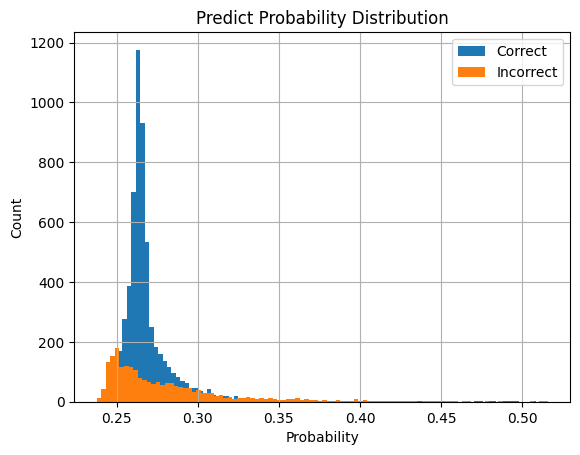

In [14]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [15]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.273375
std       0.029213
min       0.237934
max       0.515790
median    0.265037
Name: predict_probability, dtype: float64

In [17]:
thresholds = [0, 0.1, 0.2, 0.25, 0.3]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_22432/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_22432/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_22432/3327794854.py:2: RuntimeWarning: invalid value encountered in long_scalars
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.731456,1.000000,0.000000,0.000000
0.10,0.731456,1.000000,0.000000,0.000000
0.20,0.731456,1.000000,0.000000,0.000000
0.25,0.764304,0.925094,0.325770,0.074906
0.30,0.443654,0.102343,0.764268,0.897657
